# Okay, goals for Week 1-2:
Set up a python environment with all the software tools we'll be using. This includes numpy, matplotlib, astropy, lightkurve, and the things they require as dependencies.

1. Get some practice downloading and interacting with TESS data! I recommend doing a few of the tutorials here, specifically "What are light curves" "recover a planet" and "how to detrend" but also any other ones you find interesting. ✔

2. Have a read through of this paper if you haven't already: https://iopscience.iop.org/article/10.3847/1538-3881/ac223a Make a light curve with TESS data ✔, and measure the relative spacing of the primary and secondary eclipses. ✔

3. Download the WASP, KELT and ASAS-SN data (ASAS-SN ✔ is easiest, start there) for this target and see if you can reproduce their Figure 5, top panels. If we measure the period of the primary and secondary eclipses separately, do you see a difference? Is it significant?

In [1]:
import requests
import re
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from lightkurve import search_lightcurvefile
import pandas as pd
import os

%matplotlib inline

Let's access the TESS data and plot a light curve for it. We can use built-in python functions to search for the TESS object without having to interact with a website manually.

/Users/carolshao/anaconda3/envs/tess_cbp/lib/python3.12/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 14 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


19.853851226963293 d


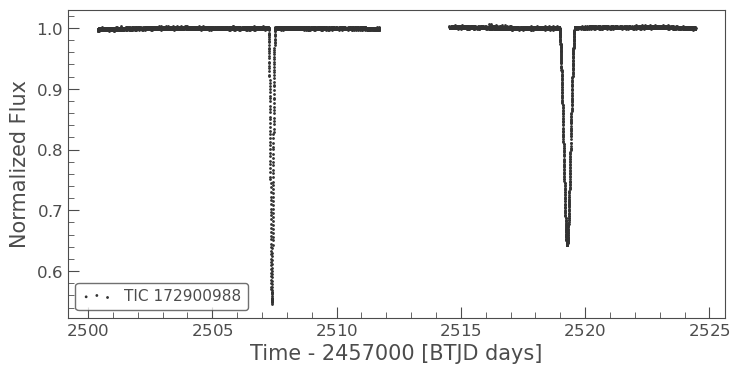

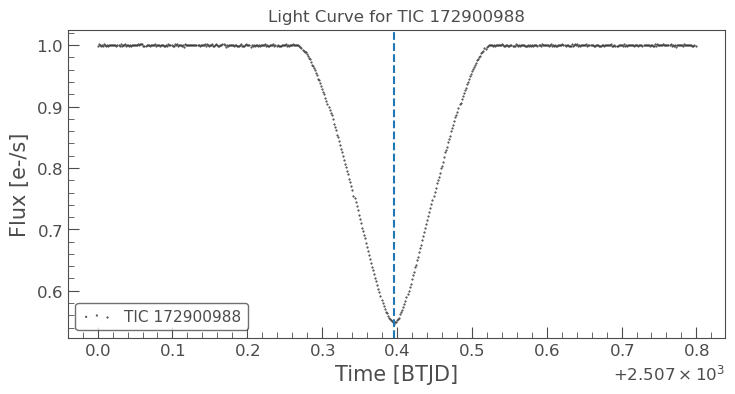

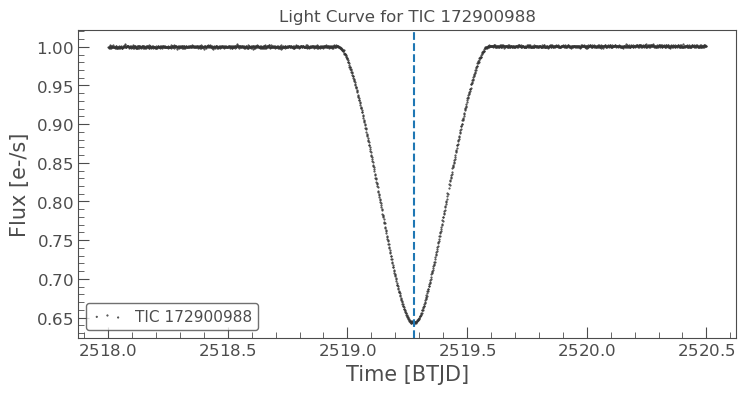

In [2]:
search_result = lk.search_lightcurve('TIC 172900988', mission='TESS')

# download the light curve data
lc = search_result.download().remove_nans().normalize()
lc.scatter()
periodogram = lc.to_periodogram(method='bls', minimum_period=18, maximum_period=20, duration=[0.3,0.5])
best_period = periodogram.period_at_max_power
print(best_period)

cropped_lc1 = lc[(lc.time.value >= 2507) & (lc.time.value <= 2507.8)]
cropped_lc2 = lc[(lc.time.value >= 2518) & (lc.time.value <= 2520.5)]

# for now, we manually identify the peak of the primary eclipse, for rough reference purposes
cropped_lc1.scatter(s=1)
plt.xlabel('Time [BTJD]')
plt.ylabel('Flux [e-/s]')
plt.axvline(x=2507.396, linestyle='--') 
plt.title('Light Curve for TIC 172900988')
plt.show()

cropped_lc2.scatter(s=1)
plt.xlabel('Time [BTJD]')
plt.ylabel('Flux [e-/s]')
plt.axvline(x=2519.278, linestyle='--') 
plt.title('Light Curve for TIC 172900988')
plt.show()

In [3]:
search_result = lk.search_lightcurve('TIC 172900988', mission='TESS')
search_result[0]

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 44,2021,SPOC,120,172900988,0.0


Search for the TESS object using search_tesscut module and use the extracted coordinates to query for the same object in ASAS-SN data. There is something called 'pyasassn' which uses query language similar to SQL which will be helpful to us.

In [4]:
from lightkurve import search_tesscut
from pyasassn.client import SkyPatrolClient
import astroquery
from astroquery.mast import Catalogs

tic_id = 'TIC 172900988'

# query the TIC catalog for the target
tic_info = Catalogs.query_object(tic_id, radius=0.001, catalog="TIC")
    
if tic_info is not None and len(tic_info) > 0:
    # extract RA, Dec, and radius
    ra = tic_info[0]['ra']
    dec = tic_info[0]['dec']
    radius = tic_info[0]['rad']

    print(f"TIC ID: {tic_id}")
    print(f"RA: {ra} degrees")
    print(f"Dec: {dec} degrees")
    print(f"Radius: {radius} solar radii")
else:
    print(f"No information found for TIC ID: {tic_id}")

client = SkyPatrolClient()
client.catalogs.master_list

# query for the asas-sn object id
query = """
SELECT 
 * 
FROM master_list 
WHERE DISTANCE(ra_deg, dec_deg, 128.661697628763, 31.554078073408) <= 0.01
"""
asassn_lc = client.adql_query(query, download=True)

TIC ID: TIC 172900988
RA: 128.661697628763 degrees
Dec: 31.554078073408 degrees
Radius: 2.02879 solar radii
Welcome to ASAS-SN Skypatrol!

Current Deployment Version: 0.6.17 (26 JAN 2024)
Please upgrade your client if not up to date.

Pulled 1 of 1


In [5]:
asassn_lc

LightCurveCollection with 1 light curves 
     asas_sn_id      ra_deg    dec_deg                catalog_sources
0  171799744865  128.661664  31.553979  [stellar_main, tic, aavsovsx]

Add a quality flag filter onto the data and remove the invalid negative flux points. We also normalize the data using the median overall flux and then make the data into a dataframe (to then be converted into a lightkurve obj).

Best period: 19.7148 d days


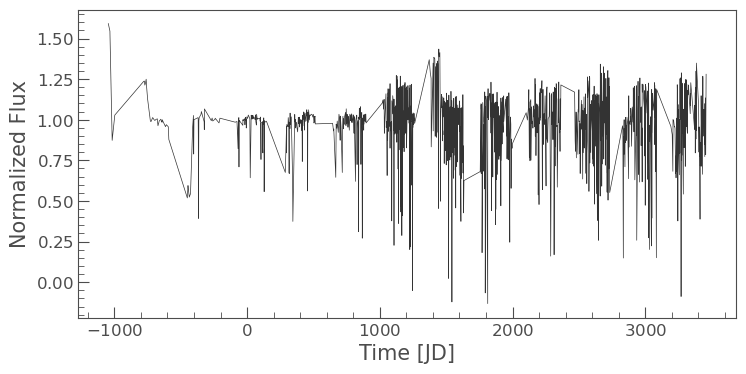

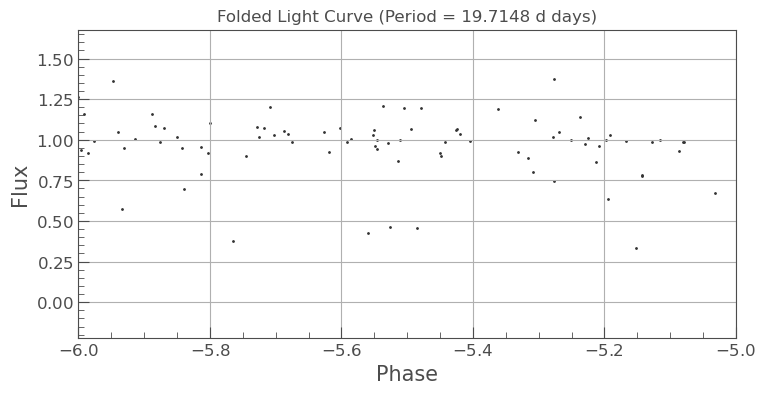

In [6]:
lightcurve = asassn_lc[171799744865]

data = {
    'jd': (lightcurve.data['jd'] - 2457000),  
    'flux': (lightcurve.data['flux'] / np.median(lightcurve.data['flux']))
}
asassn_df = pd.DataFrame(data)

lc = lk.LightCurve(time=asassn_df['jd'], flux=asassn_df['flux'])
lc = lc.flatten(break_tolerance=50, polyorder=1, sigma=3, niters=3, window_length=250)
lc.plot()
# plt.show()

periodogram = lc.to_periodogram(method='bls', minimum_period=19.5, maximum_period=20)

best_period = periodogram.period_at_max_power
print(f"Best period: {best_period:.4f} days")
folded_lc = lc.fold(period=best_period.value)

folded_lc.scatter()
plt.title(f'Folded Light Curve (Period = {best_period:.4f} days)')
plt.xlabel('Phase')
plt.xlim(-6, -5) # zooming in on the primary eclipse
plt.ylabel('Flux')
plt.grid(True)
plt.show()

Below, we see that data does not exist for the Kepler mission. Kepler only covered 5% of the sky, so this also makes sense. There is also no mission ID for this object on the SIMBAD database.

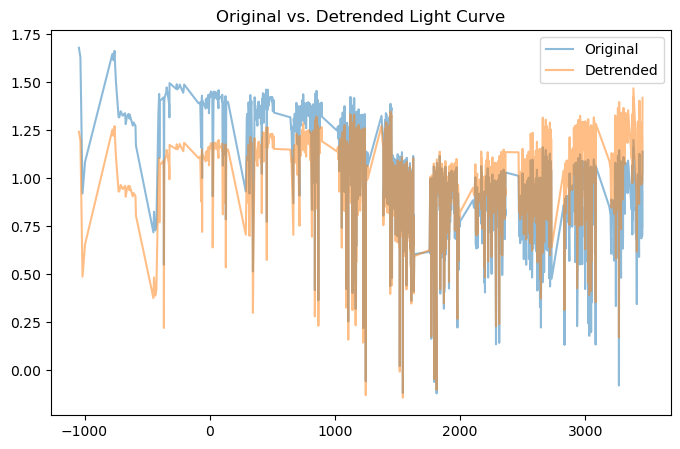

In [7]:
from sklearn.linear_model import LinearRegression


time = asassn_df['jd'].values.reshape(-1, 1)
flux = asassn_df['flux'].values

# fit the linear regression model
model = LinearRegression()
model.fit(time, flux)
trend = model.predict(time)

# detrend the data
detrended_flux = flux - trend + 1

plt.figure(figsize=(8, 5))
plt.plot(asassn_df['jd'], asassn_df['flux'], label='Original', alpha=0.5)
plt.plot(asassn_df['jd'], detrended_flux, label='Detrended', alpha=0.5)
plt.legend()
plt.title('Original vs. Detrended Light Curve')
plt.show()

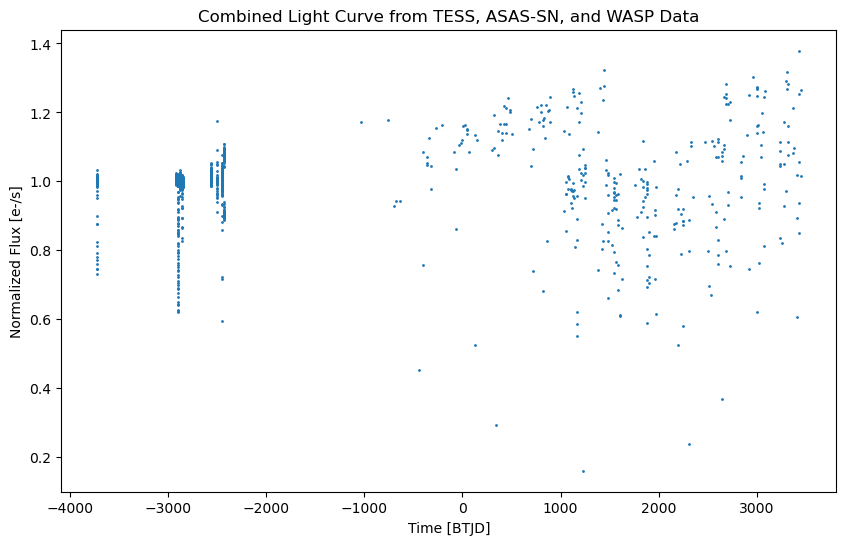

In [10]:
from lightkurve import LightCurve, search_lightcurve
import warnings
warnings.filterwarnings('ignore')

### THE TESS DATA ###
search_result = lk.search_lightcurve('TIC 172900988', mission='TESS')
tess_lc = search_result.download().remove_nans().normalize()
tess_df = pd.DataFrame({
    'jd': tess_lc.time.value,
    'flux': tess_lc.flux.value
})

### THE ASAS-SN DATA ###

asassn_data = {
    'jd': lightcurve.data['jd'] - 2457000,
    'flux': detrended_flux / np.median(detrended_flux)
}
asassn_df = pd.DataFrame(asassn_data)

### THE WASP DATA ###
with open('output/TIC 172900988/1SWASP_J083438.80+313314.7_lc.tbl', 'r') as my_file:
    for _ in range(22):
        next(my_file)
    
    data = []
    for line in my_file:
        fields = line.split()
        tamflux_value = float(fields[3])
        hjd_value = float(fields[9])
        data.append({'jd': hjd_value, 'flux': tamflux_value})

wasp_df = pd.DataFrame(data)
wasp_df['flux'] = wasp_df['flux'] / (wasp_df['flux'].median()) # normalize
wasp_df['jd'] = wasp_df['jd'] - 2457000 # same units as everything else smh

# COMBINE
combined_df = pd.concat([asassn_df, wasp_df])
combined_df = combined_df.loc[combined_df['flux'] >= 0]

##############################################

# calculate all the possible primary transits
primary_transit = 2507.398
period = 19.6583
primary_lower = np.arange(primary_transit, np.min(combined_df["jd"]) - period, -period)
primary_upper = np.arange(primary_transit + period, np.max(combined_df["jd"]) + period, period)
transit_times = np.concatenate((primary_lower, primary_upper))

def filter_data_around_transits(df, transit_times, window=2):
    """
    Filters the DataFrame to include only rows where the jd value falls within the window around each transit time.
    
    Parameters:
    - df: DataFrame containing the time series data.
    - transit_times: Array of transit times.
    - window: Number of days around each transit time to consider for filtering.
    
    Returns:
    - Filtered DataFrame.
    """
    mask = pd.Series(False, index=df.index)
    for transit in transit_times:
        lower_bound = transit - window
        upper_bound = transit + window
        mask |= (df['jd'] >= lower_bound) & (df['jd'] <= upper_bound)
    return df[mask]
    
filtered_df = filter_data_around_transits(combined_df, transit_times)
# Now, filtered_df contains only the data points within the specified window around each transit time.

plt.figure(figsize=(10, 6))
plt.scatter(filtered_df['jd'], filtered_df['flux'], label='Filtered Data', s=1)

plt.xlabel('Time [BTJD]')
plt.ylabel('Normalized Flux [e-/s]')
plt.title('Combined Light Curve from TESS, ASAS-SN, and WASP Data')
plt.show()

lc = lk.LightCurve(time=filtered_df['jd'], flux=filtered_df['flux']).remove_nans().normalize()
lc = lc.flatten(break_tolerance=500, polyorder=1, sigma=3, niters=10, window_length=250) # we can play with these inputs further

Best period: 19.6583 d days


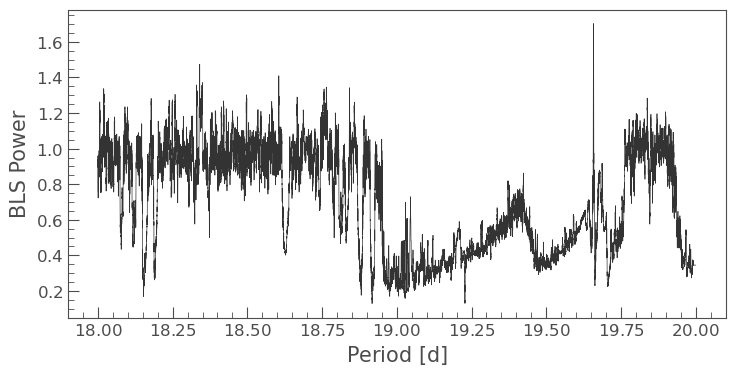

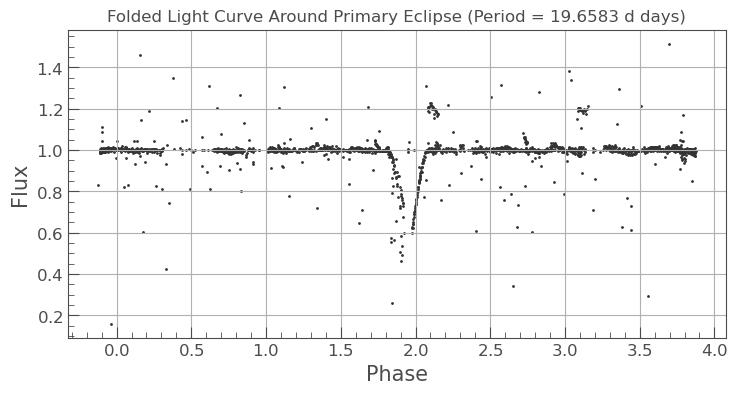

In [11]:
duration = [0.3, 0.5]
periodogram = lc.to_periodogram(method='bls', minimum_period=18, maximum_period=20, duration=duration)

best_period = periodogram.period_at_max_power
print(f"Best period: {best_period:.4f} days")
folded_lc = lc.fold(period=best_period.value)
periodogram.plot()

folded_lc.scatter()
plt.title(f'Folded Light Curve Around Primary Eclipse (Period = {best_period:.4f} days)')
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.grid(True)
plt.show()

Best period: 19.8149 d days


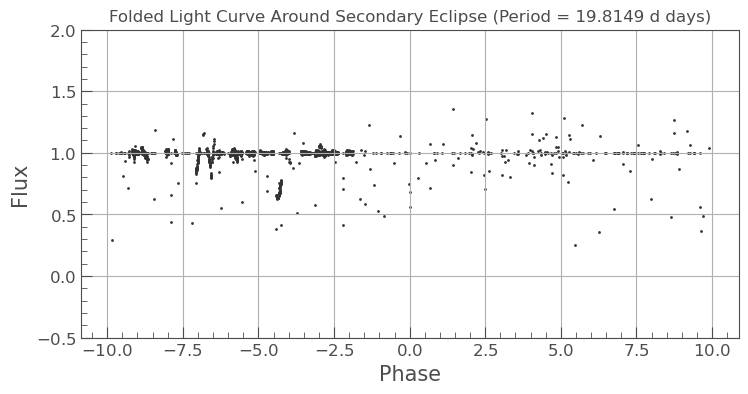

Difference: 0.1565 d


In [12]:
# repeating for the secondary eclipse
secondary_transit = 2519.3

secondary_lower = np.arange(secondary_transit, np.min(combined_df["jd"]) - period, -period)
secondary_upper = np.arange(secondary_transit + period, np.max(combined_df["jd"]) + period, period)
secondary_transit_times = np.concatenate((secondary_lower, secondary_upper))

secondary_filtered_df = filter_data_around_transits(combined_df, secondary_transit_times)

lc2 = lk.LightCurve(time=secondary_filtered_df['jd'], flux=secondary_filtered_df['flux'])
lc2 = lc2.flatten(break_tolerance=500, polyorder=1, sigma=3, niters=10, window_length=250) # we can play with these inputs further

periodogram2 = lc2.to_periodogram(method='bls', minimum_period=18, maximum_period=20, duration=duration)

best_period2 = periodogram2.period_at_max_power
print(f"Best period: {best_period2:.4f} days")
folded_lc2 = lc2.fold(period=best_period2.value)

folded_lc2.scatter()
plt.title(f'Folded Light Curve Around Secondary Eclipse (Period = {best_period2:.4f} days)')
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.ylim(-0.5,2)
plt.grid(True)
plt.show()

print("Difference: {0:.4f}".format(best_period2 - best_period))

Reading in data from WASP (obtained from wget script). The first 22 lines are header information and not useful to us, so we will skip all of them to get the actual measurements from the telescope. As a sanity check, see that NUMRECORDS = 9067 is the same as the row dimension we ultimately get, also 9067.

That's a good set there, but a stretch goal once you get beyond those is to start looking at the TESS catalog of eclipsing binaries: https://tessebs.villanova.edu/. Which of these would make good candidates for us to look across these catalogs for precession? We will need: Both primary and secondary eclipses to be observable, a nonzero eccentricity (so the phase of the secondary relative to the primary is in 0<phi<0.48 or 0.52<phi<1.0, or thereabouts, and them to not be too close/a contact binary/having strong tidal interactions, so we probably want to toss anything with an orbital period < 1 day. That might grow outwards to 2, 3, or 5 days, but that's a good starting point. With those constraints, how many candidates do we have to explore?


We will use TESS as the ground truth. 

In [22]:
import warnings
import math
import pyvo
from lightkurve import search_lightcurve
import tqdm
warnings.filterwarnings('ignore')

def round_to_decimal_place(num, decimal_places=3):
    """Round a number to a specified number of decimal places."""
    factor = 10 ** decimal_places
    
    lower_num = math.floor(num * factor) / factor
    upper_num = math.ceil(num * factor) / factor
    
    return lower_num, upper_num
    
def get_wasp(tid, ra, dec):
    lower_ra, upper_ra = round_to_decimal_place(ra, 3)
    lower_dec, upper_dec = round_to_decimal_place(dec, 3)
    
    tap_service_url = "https://exoplanetarchive.ipac.caltech.edu/TAP"
    tap_service = pyvo.dal.TAPService(tap_service_url)
    
    adql_query = f"""
    SELECT *
    FROM superwasptimeseries	
    WHERE superwasptimeseries.ra>{lower_ra} AND superwasptimeseries.ra<{upper_ra} AND
          superwasptimeseries.dec>{lower_dec} AND superwasptimeseries.dec<{upper_dec}
    """
    result = tap_service.search(adql_query)
    light_curve = result.to_table()

    if len(light_curve) == 0:
        return
    
    wasp_id = light_curve['sourceid'][0].replace(' ', '_')    
    tile = light_curve['tile'][0]

    data_url = f'http://exoplanetarchive.ipac.caltech.edu:80/data/ETSS//SuperWASP/TBL/DR1/{tile}/{wasp_id}_lc.tbl'
    
    # create the directory if it doesn't exist
    directory = f'output/{tid}'
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # save the data to a file with progress bar
    file_name = f'{wasp_id}_lc.tbl'
    file_path = os.path.join(directory, file_name)
    
    response = requests.get(data_url, stream=True)
    response.raise_for_status()  # Raise an exception for HTTP errors
    
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024
    
    with open(file_path, 'wb') as file, tqdm.tqdm(
        desc=file_name,
        total=total_size,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in response.iter_content(block_size):
            bar.update(len(data))
            file.write(data)

    return file_path


def filter_data_around_transits(df, transit_times, window=2):
    """
    Filters the DataFrame to include only rows where the jd value falls within the window around each transit time.
    
    Parameters:
    - df: DataFrame containing the time series data.
    - transit_times: Array of transit times.
    - window: Number of days around each transit time to consider for filtering.
    
    Returns:
    - Filtered DataFrame.
    """
    mask = pd.Series(False, index=df.index)
    for transit in transit_times:
        lower_bound = transit - window
        upper_bound = transit + window
        mask |= (df['jd'] >= lower_bound) & (df['jd'] <= upper_bound)
    return df[mask]


def filter_data(df, quality, flux_threshold):
    """Filter data based on quality and flux."""
    return df[(df['quality'] == quality) & (df['flux'] >= flux_threshold)]


def detrend_data(df):
    """Fit linear regression model to predict detrended data."""
    time = df['jd'].values.reshape(-1, 1)
    flux = df['flux'].values
    
    model = LinearRegression()
    model.fit(time, flux)
    trend = model.predict(time)
    
    detrended_flux = flux - trend + 1

    df['flux'] = detrended_flux

    return df
    

def add_tess_points(df):
    """
    Augments a given DataFrame with additional rows to ensure that consecutive 'jd' values are at least 0.1 units apart.
    """
    df['jd_diff'] = df['jd'].diff()
    
    filtered_rows = df[df['jd_diff'] > 0.1]
    
    # for each group of consecutive 'jd' values that are less than or equal to 0.1 apart,
    # create a new row with 'jd' incremented by 0.1 and 'flux' set to 1.0
    new_rows = []
    for _, group in filtered_rows.groupby(filtered_rows.index // 10):
        new_row = {'jd': group.iloc[0]['jd'] + 0.1 * len(group), 'flux': 1.0}
        new_rows.append(new_row)
    
    combined_rows = pd.concat([df.drop(columns=['jd_diff']), pd.DataFrame(new_rows)])
    
    final_df = combined_rows.drop_duplicates(subset='jd', keep='first')
    
    final_df.reset_index(drop=True, inplace=True)
    return final_df


def chi_squared(tess_df, comparison_df, period, transit):
    folded_tess = lk.LightCurve(time=tess_df['jd'], 
                             flux=tess_df['flux']).fold(period=period, epoch_time=transit)
    folded_comparison = lk.LightCurve(time=comparison_df['jd'], 
                               flux=comparison_df['flux']).fold(period=period, epoch_time=transit)

    folded_tess_df = pd.DataFrame({'jd': folded_tess.time.value, 'flux': folded_tess.flux.value})
    folded_comparison_df = pd.DataFrame({'jd': folded_comparison.time.value, 'flux': folded_comparison.flux.value, 
                                         'flux_err': comparison_df['flux_err']}) # we already calculated and added 'flux_err' previously

    # calculate sd of comparison dataset's flux errors


    comparison_err = np.std(folded_comparison_df['flux'])
    chi_squared_values = []
    chi_squared_sum = 0
    
    for _, row in folded_comparison_df.iterrows():
        comparison_phase = row['jd']
        comparison_flux = row['flux']
        
        differences = np.abs(folded_tess_df['jd'] - comparison_phase)
    
        closest_idx = differences.argmin()
        
        closest_tess_flux = folded_tess_df.loc[closest_idx, 'flux']
        
        chi_squared = ((comparison_flux - closest_tess_flux) / comparison_err)**2
        chi_squared_sum += chi_squared
        
    return chi_squared_sum


def automate_periodogram(tid, primary_transit, secondary_transit, min_period, max_period):
    """
    Generates a primary periodogram for a given TESS ID, incorporating WASP and ASAS-SN data.

    Parameters:
    - tid (str): TESS ID of the target.
    - primary_transit (float): JD of primary transit epoch.
    - secondary_transit (float): JD of secondary transit epoch.
    - min_period (float): Minimum period for periodogram.
    - max_period (float): Maximum period for periodogram.

    Displays a plot of the best predicted period by lowest chi-squared.
    """
    # get the TESS data
    try:
        tid_str = str(tid)
        search_result = search_lightcurve(tid_str, mission='TESS')
        tess_lc = search_result.download().remove_nans().normalize()
    except Exception as e:
        print(f"Error processing {tid} ({type(e).__name__}): {e}")

    # detrend method requires a df, so convert tess_lc to a dataframe
    tess_df = pd.DataFrame({
        'jd': tess_lc.time.value,
        'flux': tess_lc.flux.value
    })
    tess_df = detrend_data(tess_df)

    # also add points to tess
    tess_df = add_tess_points(tess_df)

    base_dir = f'output/{tid}'
    asassn_df = None
    
    for item in os.listdir(base_dir):
        
        # attempt to open the file starting with "asas_sn_id..."
        for filename in os.listdir(base_dir):
            if filename.startswith("asas_sn_id"):
                with open(os.path.join(base_dir, filename), 'r') as file:
                    
                    # read the file content into a DataFrame
                    asassn_df = pd.read_csv(file, skiprows=1)

    # step 1: filter
    asassn_df = filter_data(asassn_df, 'G', 0)

    # step 2: normalize
    asassn_median = asassn_df['flux'].median()
    
    asassn_data = {
        'jd': asassn_df['jd'] - 2457000,
        'flux': asassn_df['flux'] / asassn_median,
        'flux_err': asassn_df['flux_err'],
        'phot_filter': asassn_df['phot_filter']
    }
    asassn_df = pd.DataFrame(asassn_data)

    # step 3: detrend
    filters = ['g', 'V']
    all_detrended_data = []
    
    for filter_type in filters:
        filtered_data = asassn_df[asassn_df['phot_filter'] == filter_type]
    
        all_detrended_data.append(detrend_data(filtered_data))

    detrended_asassn_df = pd.concat(all_detrended_data)

    asassn_detrended = {
        'jd': detrended_asassn_df['jd'],
        'flux': detrended_asassn_df['flux'],
        'flux_err': asassn_df['flux_err'] / (detrended_asassn_df['flux']).median(),
    }
    
    asassn_df = pd.DataFrame(asassn_detrended)


    for item in os.listdir(base_dir):
        
        # attempt to open the file starting with "1SWASP"
        for filename in os.listdir(base_dir):
            if filename.startswith("1SWASP"):
                wasp_filepath = os.path.join(base_dir, filename)
    
    # obtain the wasp data
    with open(wasp_filepath, 'r') as my_file:
        for _ in range(22):
            next(my_file)
        
        data = []
        for line in my_file:
            fields = line.split()
            tamflux2_value = float(fields[3])
            tamflux2_err_value = float(fields[4])
            hjd_value = float(fields[9])
            data.append({'jd': hjd_value, 'flux': tamflux2_value, 'flux_err': tamflux2_err_value})
    
    wasp_df = pd.DataFrame(data)
    
    # normalize
    wasp_median = wasp_df['flux'].median()
    
    wasp_data = {
        'jd': wasp_df['jd'] - 2457000,
        'flux': wasp_df['flux'] / wasp_median,
        'flux_err': wasp_df['flux_err'] / wasp_median,
    }
    wasp_df = pd.DataFrame(wasp_data)

    # detrend wasp
    wasp_df = detrend_data(wasp_df)

    # add labels
    tess_df['dataset_marker'] = 'TESS'
    asassn_df['dataset_marker'] = 'ASAS-SN'
    wasp_df['dataset_marker'] = 'SWASP'
  
    # combine the data + filter 
    combined_df = pd.concat([tess_df, asassn_df, wasp_df])
    combined_df.to_csv(f'output/{tid}/combined_data.csv', index=False) # TODO: fix

    # period calculation using minimizing chi-squared method:
    periods = np.arange(min_period, max_period, 0.0001)

    best_predicted_periods = []
    transits = [primary_transit, secondary_transit]
    fig, axs = plt.subplots(2, figsize=(12, 10))  # Adjust figsize as needed

    for i, transit in enumerate(transits):
        chi_squared_values = []
    
        for period in periods:
            transit_times = np.concatenate((np.arange(transit, np.min(combined_df["jd"]) - period, -period), 
                                            np.arange(transit + period, np.max(combined_df["jd"]) + period, period)))
    
            filtered_tess_df = filter_data_around_transits(tess_df, transit_times)
            filtered_asassn_df = filter_data_around_transits(asassn_df, transit_times)
            filtered_wasp_df = filter_data_around_transits(wasp_df, transit_times)
            
            chi_squared_sum = chi_squared(filtered_tess_df, filtered_asassn_df, period, transit) + chi_squared(filtered_tess_df, filtered_wasp_df, period, transit)
    
            chi_squared_values.append(chi_squared_sum)
    
        best_predicted_period = periods[np.argmin(chi_squared_values)]
        best_predicted_periods.append(best_predicted_period)

        axs[i].plot(periods, chi_squared_values)
        index_of_best_period = list(periods).index(best_predicted_period)
        axs[i].plot(best_predicted_period, chi_squared_values[index_of_best_period], 'ro')
        axs[i].set_xlabel('Period')
        axs[i].set_ylabel('Chi-Squared')
        axs[i].set_title(f'Best Predicted Period: {best_predicted_period:.5f}')
        axs[i].grid()

    plt.savefig(f'output/{tid}/periodogram.png')
    plt.tight_layout()  # Adjust subplot parameters to give specified padding
    plt.show()

    # write predicted periods to csv file
    # tess_eb_df = pd.read_csv('tess_ebs_data copy.csv')
    
    # filtered_row = tess_eb_df[tess_eb_df['tid'] == tid]
    
    # filtered_row.loc[:, 'predicted_primary_period'] = best_predicted_periods[0] 
    # filtered_row.loc[:, 'predicted_secondary_period'] = best_predicted_periods[1]
    # tess_eb_df.update(filtered_row)
    # tess_eb_df.to_csv('tess_ebs_data.csv', index=False)
    
    return best_predicted_periods

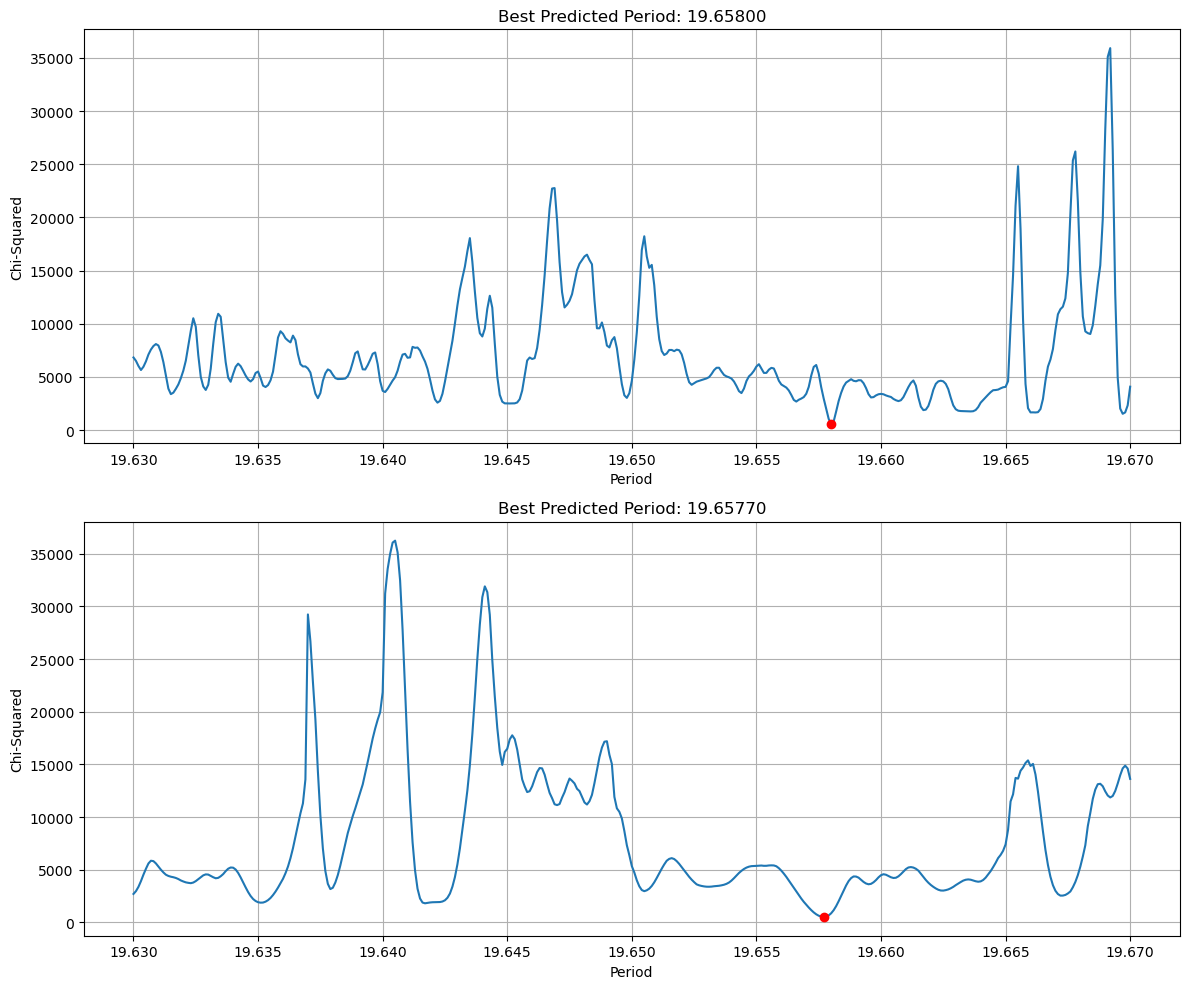

In [39]:
# predicted period
fold_periods = automate_periodogram(tid='TIC 172900988', primary_transit=2507.396, secondary_transit=2519.278, 
                                    min_period=19.63, max_period=19.67)

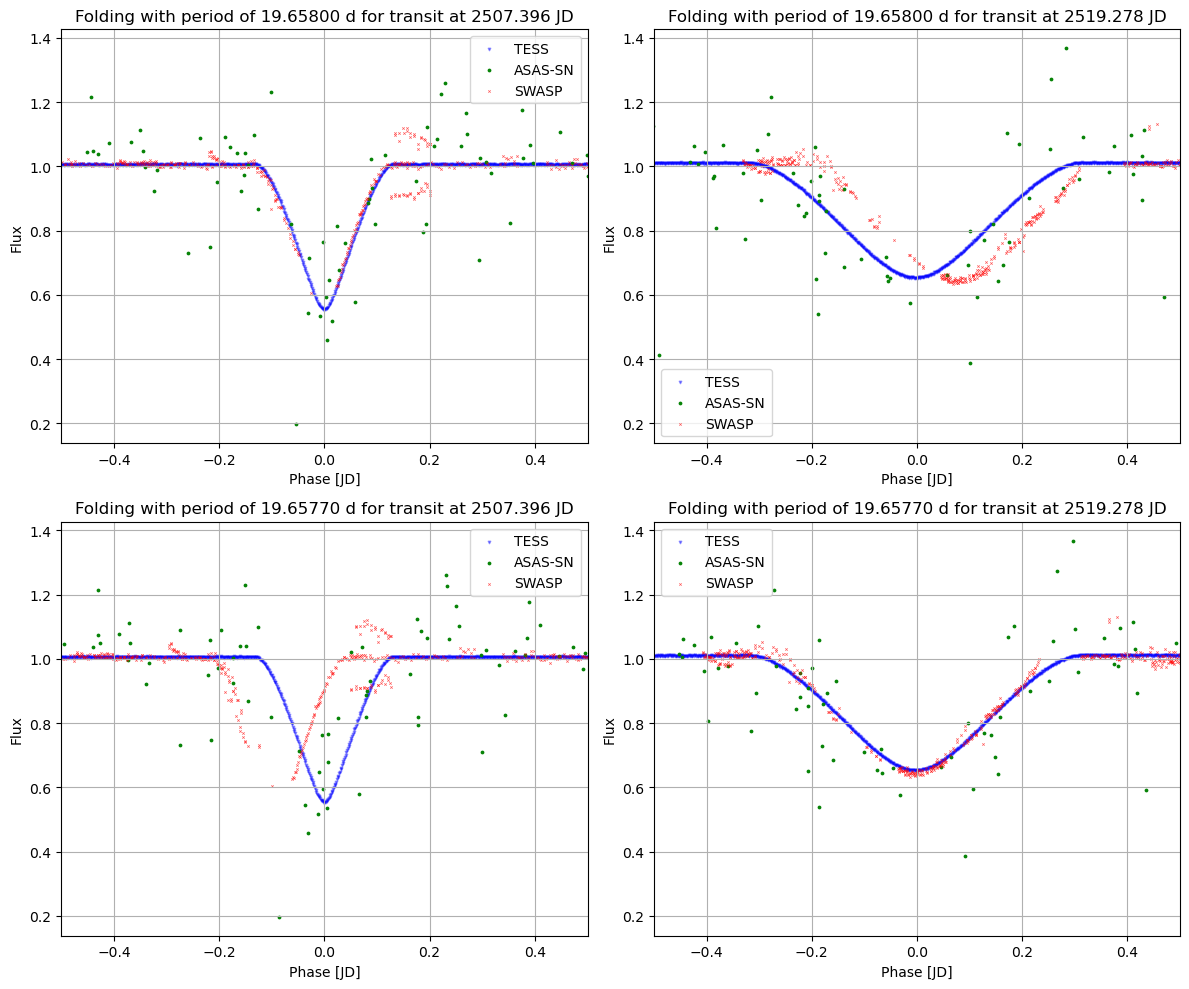

In [40]:
import pandas as pd
from lightkurve import LightCurve
import matplotlib.pyplot as plt

def detect_precession(tid, fold_periods, primary_transit, secondary_transit):
    
    df = pd.read_csv(f'output/{tid}/combined_data.csv')
    marker_to_color = {'TESS': 'blue', 'ASAS-SN': 'green', 'SWASP': 'red'}
    marker_to_shape = {'TESS': 'v', 'ASAS-SN': 'o', 'SWASP': 'x'}  # Define shapes here
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    
    transits = [primary_transit, secondary_transit]
    
    plot_idx = 0
    
    # Calculate dataset proportions
    dataset_counts = df['dataset_marker'].value_counts().sort_index()
    total_count = len(df)
    dataset_proportions = 1 - dataset_counts / total_count
    
    for period in fold_periods:
        for transit in transits:
            ax = axs[plot_idx // 2, plot_idx % 2]
            
            for marker, color in marker_to_color.items():
                marker_df = df[df['dataset_marker'] == marker]
                
                shape = marker_to_shape.get(marker, 'o')  
                folded_lc = lk.LightCurve(time=marker_df['jd'], flux=marker_df['flux']).fold(period=period, epoch_time=transit)
                
                # Set alpha based on dataset proportion
                alpha = dataset_proportions.loc[marker]  # Assuming the index is the marker name
                
                folded_lc.scatter(ax=ax, s=3, color=color, label=marker, marker=shape, alpha=alpha)
            
            ax.set_title(f'Folding with period of {period:.5f} d for transit at {transit} JD')
            ax.legend()
            ax.set_xlim(-0.5,0.5)
            ax.grid()
            
            plot_idx += 1
    
    plt.tight_layout()
    plt.savefig(f'output/{tid}/folded.png')
    plt.show()

# Example usage remains the same
detect_precession(tid='TIC 172900988', fold_periods=fold_periods, primary_transit=2507.396, secondary_transit=2519.278)


In [48]:
from bokeh.plotting import figure, output_file, show, save
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource, HoverTool, Range1d

def detect_precession_bokeh(tid, fold_periods, primary_transit, secondary_transit):
    
    df = pd.read_csv(f'output/{tid}/combined_data.csv')
    marker_to_color = {'TESS': 'blue', 'ASAS-SN': 'green', 'SWASP': 'red'}
    marker_to_shape = {'TESS': 'v', 'ASAS-SN': 'o', 'SWASP': 'x'}  # Define shapes here
    
    plots = []
    transits = [primary_transit, secondary_transit]
    
    # Calculate dataset proportions
    dataset_counts = df['dataset_marker'].value_counts().sort_index()
    total_count = len(df)
    dataset_proportions = 1 - dataset_counts / total_count
    
    for period in fold_periods:
        for transit in transits:
            p = figure(title=f'Folding with period of {period:.5f} d for transit at {transit} JD', 
                       x_axis_label='Phase', y_axis_label='Flux', width=600, height=600)
            
            for marker, color in marker_to_color.items():
                marker_df = df[df['dataset_marker'] == marker]
                shape = marker_to_shape.get(marker, 'o')  
                folded_lc = LightCurve(time=marker_df['jd'], flux=marker_df['flux']).fold(period=period, epoch_time=transit)
                
                # Set alpha based on dataset proportion
                alpha = dataset_proportions.loc[marker]  # Assuming the index is the marker name
                
                source = ColumnDataSource(data=dict(phase=folded_lc.time.value, flux=folded_lc.flux, marker=[marker]*len(folded_lc.time)))
                p.scatter('phase', 'flux', source=source, size=3, color=color, alpha=alpha, legend_label=marker, marker=shape)
            
            p.legend.title = 'Datasets'
            p.legend.location = 'top_left'
            p.add_tools(HoverTool(tooltips=[("Phase", "@phase"), ("Flux", "@flux"), ("Dataset", "@marker")]))
            p.x_range = Range1d(-0.5, 0.5)
            p.xgrid.grid_line_color = None
            p.ygrid.grid_line_color = None
            plots.append(p)
    
    grid = gridplot([plots[i:i+2] for i in range(0, len(plots), 2)])
    output_file(f'output/{tid}/folded.html')
    save(grid)
    show(grid)

# Example usage remains the same
detect_precession_bokeh(tid='TIC 172900988', fold_periods=fold_periods, primary_transit=2507.396, secondary_transit=2519.278)

0:94: execution error: File some object wasn’t found. (-43)


In [ ]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

In [ ]:
%%skip
import re
from IPython.display import display

def extract_numbers_from_file(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
        # match the nums following 'TIC '
        pattern = r"TIC\s+(\d+)"
        
        ids_list = []
        matches = re.findall(pattern, content)
        
        for match in matches:
            ids_list.append(match)
    
    return ids_list

file_path = 'tess_ebs.txt'
ids_list = extract_numbers_from_file(file_path)

In [ ]:
%%skip
from bs4 import BeautifulSoup

rows = []

for id in tqdm.tqdm(ids_list, desc="Processing URLs"):
    url = f'https://tessebs.villanova.edu/{id}'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    column_names_html = [
        "α [o]Right ascension",
        "δ [o]Declination",
        "t0 [days]Time of superior conjunction",
        "P [days]Orbital period in days",
        "φp,pfPolyfit phase of the primary eclipse",
        "φs,pfPolyfit phase of the secondary eclipse"
    ]
    
    values_dict = {}
    
    tables = soup.find_all('table')
    for i, table in enumerate(tables):
        df_table = pd.read_html(str(table))[0]
        
        for col_name in column_names_html:
            if col_name in df_table.columns:
                values_dict[col_name] = df_table[col_name].tolist()[0]
    
    if values_dict:
        ra = values_dict["α [o]Right ascension"]
        dec = values_dict["δ [o]Declination"]
        t0 = values_dict["t0 [days]Time of superior conjunction"]
        P = values_dict["P [days]Orbital period in days"]
        φp_pf = values_dict["φp,pfPolyfit phase of the primary eclipse"]
        φs_pf = values_dict["φs,pfPolyfit phase of the secondary eclipse"]
        
        new_row = {
            "tid": f"TIC {id}",
            "ra": ra,
            "dec": dec,
            "primary_transit": t0,
            "secondary_transit": float(t0) + (float(φp_pf) - float(φs_pf)) * float(P),
            "period": P,
            "phase_difference": float(φp_pf) - float(φs_pf)
        }
        
        rows.append(new_row)

df = pd.DataFrame(rows)

In [ ]:
%%skip
df.to_csv('tess_ebs_data.csv', index=False)

In [ ]:
def get_asas_sn(tid, ra, dec):
    client = SkyPatrolClient()
    client.catalogs.master_list
    
    # query for the asas-sn object id
    query = f"""
    SELECT 
     * 
    FROM master_list 
    WHERE DISTANCE(ra_deg, dec_deg, {ra}, {dec}) <= 0.001
    """
    try:
        asassn_query = client.adql_query(query, download=True)
    except Exception as e:
        return        
    
    asassn_lc = asassn_query[asassn_query.data['asas_sn_id'][0]]
    
    output_dir = f'output/{tid}'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    asassn_lc.save(filename=f'{output_dir}/asas_sn_id_{asassn_query.data["asas_sn_id"][0]}.csv', file_format='csv')

In [ ]:
%%skip
no_kelt_tids = []
for index, row in tqdm.tqdm(df.iterrows(), total=df.shape[0]):
    tid = row['tid']
    ra = row['ra']
    dec = row['dec']
    
    lower_ra, upper_ra = round_to_decimal_place(ra, decimal_places=3)
    lower_dec, upper_dec = round_to_decimal_place(dec, decimal_places=3)
    
    tap_service_url = "https://exoplanetarchive.ipac.caltech.edu/TAP"
    tap_service = pyvo.dal.TAPService(tap_service_url)
    
    # kelt
    adql_query = f"""
    SELECT *
    FROM kelttimeseries	
    WHERE kelttimeseries.ra>{lower_ra} AND kelttimeseries.ra<{upper_ra} AND
          kelttimeseries.dec>{lower_dec} AND kelttimeseries.dec<{upper_dec}
    """
    
    result = tap_service.search(adql_query)
    light_curve = result.to_table()
    
    if len(light_curve) == 0:
        no_kelt_tids.append(tid)

In [ ]:
%%skip
print(len(no_kelt_tids))

In [ ]:
import os

base_dir = "output/"

def get_row_by_tid(tid):
    filtered_df = df[df['tid'] == tid]
    return filtered_df.iloc[0]

items = os.listdir(base_dir)
with tqdm.tqdm(total=len(items)) as pbar:
    for item in items:
        item_path = os.path.join(base_dir, item)
        
        if os.path.isdir(item_path):
            files_in_directory = os.listdir(item_path)
            
            if len(files_in_directory) == 2 and item in no_kelt_tids:
                tid = item  # 'item' is the tid here
                row = get_row_by_tid(tid)

                print(f"Processing tid: {tid}")

                # getting info about the object
                ra = row['ra']
                dec = row['dec']
                primary_transit = row['primary_transit']
                secondary_transit = row['secondary_transit']
                period = row['period']

                min_period, max_period = round_to_decimal_place(period, decimal_places=2)
                min_period -= 0.015
                max_period += 0.015

                # access the downloaded data now instead of redownloading!
                fold_periods = automate_periodogram(tid, primary_transit, secondary_transit, 
                                        min_period, max_period)

                detect_precession(tid, fold_periods, primary_transit, secondary_transit)
                
                pbar.update(1)  # update the progress bar after each successful iteration
